# Refresher on Backpropagating through Neural Networks
This will be based on the network decsribed in https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

In [2]:
def sigmoid_func(in_vec, derivative_of=False):
    if not derivative_of:
        return 1 / (1 + np.exp(-in_vec))
    base_value = sigmoid_func(in_vec, derivative_of=False)
    return np.multiply(base_value, (1 - base_value))

In [56]:
def relu_func(in_vec, derivative_of=False):
    if not derivative_of:
        return np.maximum(in_vec, 0)
    copy_vec = np.copy(in_vec)
    copy_vec[copy_vec >= 0] = 1
    copy_vec[copy_vec < 0] = 0 
    return copy_vec

In [3]:
def mean_squared_error(true_y, pred_y, derivative_of=False):
    if not derivative_of:
        return (1 / 2) * np.sum((true_y - pred_y) ** 2)
    return np.sum(pred_y - true_y)

In [4]:
def stochastic_gradient_descent(orig_layer_w, layer_delta_w, learning_rate=0.1):
    return orig_layer_w - (learning_rate * layer_delta_w)

In [5]:
class BasicModel:
    def __init__(self, init_weights, layer_activations, add_bias=True):
        self.add_bias = add_bias
        self.network_weights = np.copy(init_weights)
        self.layers_activations = np.copy(layer_activations)
        value_cache_layout = []
        for layer_weight_base in self.network_weights:
            layer_shape = layer_weight_base.shape
            value_cache_layout.append([np.zeros(layer_shape[0]), np.zeros(layer_shape[0])])
        self.network_value_cache = np.copy(value_cache_layout)
    
    def forward_pass(self, in_vec):
        output_cache = np.copy(in_vec)
        self.input_cache = np.copy(in_vec)

        for i, (layer_weights, activation) in enumerate(zip(self.network_weights, self.layers_activations)):
            if self.add_bias:
                output_cache = np.append(output_cache, 1)
            self.network_value_cache[i][0] = np.matmul(layer_weights, output_cache)
            self.network_value_cache[i][1] = activation(self.network_value_cache[i][0])
            output_cache = self.network_value_cache[i][1]
        return self.network_value_cache[self.network_value_cache.shape[0] - 1][1]
    
    def backward_pass(self, y_true):
        sigma_cache = []
        # Backprop last layer and calculate sigma oi's
        net_out, layer_out = self.network_value_cache[self.network_value_cache.shape[0] - 1]
        div_E_out = layer_out - y_true
        div_out_net = self.layers_activations[len(self.layers_activations) - 1](net_out, derivative_of=True)
        div_E_net = np.multiply(div_E_out, div_out_net)   # This is the sigma for this layer
        sigma_cache.append(div_E_net)
        
        # Backprop through rest of layers
        num_hidden_layers = self.network_value_cache.shape[0] - 1 # Subtract 1 because we take care of last layer already
        for i in reversed(range(0, num_hidden_layers)):
            net_out, layer_out = self.network_value_cache[i]
            div_E_out = np.matmul(
                np.transpose(self.network_weights[i + 1][:,:-1]), 
                sigma_cache[num_hidden_layers - i - 2]
            )
            div_out_net = self.layers_activations[i](net_out, derivative_of=True)
            div_E_net = np.multiply(div_E_out, div_out_net)
            sigma_cache.append(div_E_net)
        sigma_cache = np.array(sigma_cache)[::-1]
        
        # Forward through sigmas and w's to get dW's
        # Do first layer separately because using input X rather than previous layer output
        delta_w = []
        
        layer_input_transpose = self.input_cache
        if self.add_bias:
            layer_input_transpose = np.append(layer_input_transpose, 1)
        layer_input_transpose = layer_input_transpose.reshape((1, layer_input_transpose.shape[0]))
        div_E_w = np.matmul(sigma_cache[0].reshape((sigma_cache[0].shape[0], 1)), layer_input_transpose)
        delta_w.append(div_E_w)
        for i, layer_sigma in enumerate(sigma_cache[1:]):
            prev_net_out, prev_layer_out = self.network_value_cache[i]
            layer_input_transpose = prev_layer_out
            if self.add_bias:
                layer_input_transpose = np.append(layer_input_transpose, 1)
            layer_input_transpose = layer_input_transpose.reshape((1, layer_input_transpose.shape[0]))
            div_E_w = np.matmul(layer_sigma.reshape((layer_sigma.shape[0], 1)), layer_input_transpose)
            delta_w.append(div_E_w)
        return delta_w
    
    def update(self, delta_w, optimizer_func, lr):
        for i, layer_delta_w in enumerate(delta_w):
            self.network_weights[i] = optimizer_func(self.network_weights[i], layer_delta_w, lr)
    
    def fit_std(self, x, y_true, epochs=100, loss_function=None, optimizer_func=None, lr=0.1):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward_pass(x)
            loss_history.append(loss_function(y_true, y_pred))
            if (i % 1000) == 0:
                print('Epoch ' + str(i) + ' loss: ' + str(loss_history[len(loss_history) - 1]))
            d_w = self.backward_pass(y_true)
            self.update(d_w, optimizer_func, lr=lr)
        return loss_history

In [59]:
# Starting weights
input_vec = np.array([.05,.1])
true_y = np.array([.01,.99])
w_h = np.array([
    [.15, .25, .35],
    [.2,  .30,  .35]
])
w_o = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [60]:
model = BasicModel(init_weights=[w_h, w_o], layer_activations=[sigmoid_func, sigmoid_func])

In [61]:
model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model.fit_std(
        x=input_vec, 
        y_true=true_y, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 0.298390054478
Epoch 1000 loss: 0.000270607306793
Epoch 2000 loss: 9.03916895115e-05
Epoch 3000 loss: 4.38701323444e-05
Epoch 4000 loss: 2.48811193065e-05
Epoch 5000 loss: 1.53827598007e-05
Epoch 6000 loss: 1.00461483078e-05
Epoch 7000 loss: 6.81364579089e-06
Epoch 8000 loss: 4.75022364668e-06
Epoch 9000 loss: 3.38141035075e-06
Epoch 10000 loss: 2.4464202921e-06
Epoch 11000 loss: 1.79298956809e-06
Epoch 12000 loss: 1.32792180114e-06
Epoch 13000 loss: 9.91981307652e-07
Epoch 14000 loss: 7.46343367498e-07
Epoch 15000 loss: 5.64907152139e-07
Epoch 16000 loss: 4.29749671577e-07
Epoch 17000 loss: 3.28341370382e-07
Epoch 18000 loss: 2.51788917878e-07
Epoch 19000 loss: 1.93697297648e-07
Epoch 20000 loss: 1.49416265799e-07
Epoch 21000 loss: 1.1553150145e-07
Epoch 22000 loss: 8.95150523071e-08
Epoch 23000 loss: 6.94815553083e-08
Epoch 24000 loss: 5.4015941755e-08
Epoch 25000 loss: 4.20502180099e-08
Epoch 26000 loss: 3.2774414718e-08
Epoch 27000 loss: 2.55716274761e-08
Epoch 28000 

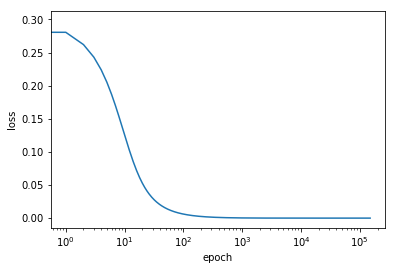

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

line, = ax1.plot(model_hist)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_xscale('log')

show()

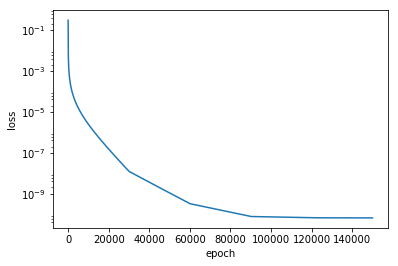

In [63]:
fig = plt.figure()
ax2 = fig.add_subplot(1,1,1)

line, = ax2.plot(model_hist)
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')

show()

In [31]:
y_pred = model.forward_pass(input_vec)
print('True y: ' + str(true_y))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [ 0.01000853  0.98999249]


In [32]:
# Starting weights
input_vec2 = np.array([.05,.1])
true_y2 = np.array([.01,.99])
w_h21 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h22 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o2 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [45]:
model_big = BasicModel(
    init_weights=[w_h21, w_h22, w_o2], 
    layer_activations=[sigmoid_func, sigmoid_func, sigmoid_func]
)

In [46]:
model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model_big.fit_std(
        x=input_vec, 
        y_true=true_y, 
        epochs=100001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 0.30830437566
Epoch 1000 loss: 0.000210366726685
Epoch 2000 loss: 6.89586821556e-05
Epoch 3000 loss: 3.27929127122e-05
Epoch 4000 loss: 1.82119823982e-05
Epoch 5000 loss: 1.10203992189e-05
Epoch 6000 loss: 7.0413320567e-06
Epoch 7000 loss: 4.67032280954e-06
Epoch 8000 loss: 3.18283449464e-06
Epoch 9000 loss: 2.21386799952e-06
Epoch 10000 loss: 1.5644492202e-06
Epoch 11000 loss: 1.11946357361e-06
Epoch 12000 loss: 8.09161572276e-07
Epoch 13000 loss: 5.89698254219e-07
Epoch 14000 loss: 4.32679872533e-07
Epoch 15000 loss: 3.19264290319e-07
Epoch 16000 loss: 2.36692028218e-07
Epoch 17000 loss: 1.76175006858e-07
Epoch 18000 loss: 1.31573427807e-07
Epoch 19000 loss: 9.85455213874e-08
Epoch 20000 loss: 7.39892228013e-08
Epoch 21000 loss: 5.56686121886e-08
Epoch 22000 loss: 4.19598696408e-08
Epoch 23000 loss: 3.16760351945e-08
Epoch 24000 loss: 2.39446173786e-08
Epoch 25000 loss: 1.81211776902e-08
Epoch 26000 loss: 1.37277319822e-08
Epoch 27000 loss: 1.040847341e-08
Epoch 28000 l

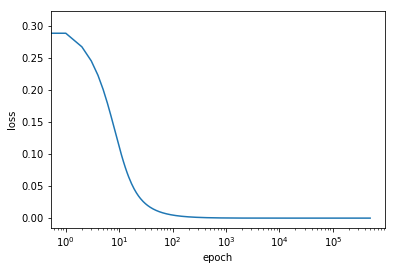

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

line, = ax1.plot(model_hist)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_xscale('log')

show()

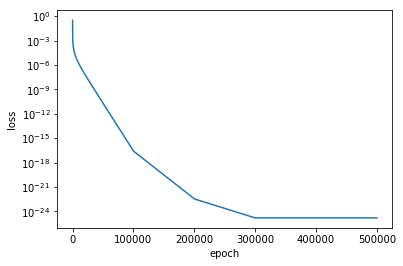

In [50]:
fig = plt.figure()
ax2 = fig.add_subplot(1,1,1)

line, = ax2.plot(model_hist)
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.set_yscale('log')

show()

In [49]:
y_pred = model_big.forward_pass(input_vec2)
print('True y: ' + str(true_y2))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [ 0.01  0.99]


In [65]:
model_big.network_weights

array([ array([[ 0.39828278,  0.29656556,  0.46565555],
       [ 0.69673126,  0.62346252,  0.26462525],
       [ 0.21480253,  0.39960506,  0.42605059]]),
       array([[ 0.41042405,  0.49537639,  0.92315088,  0.76628642],
       [ 0.46430831,  0.54896316,  0.5565346 ,  0.77261816]]),
       array([[-1.59381313, -1.45148161, -1.97847675],
       [ 1.55382308,  1.56165418,  1.91960895]])], dtype=object)